# Modelling v2

modelling use the latest exploration and use undersampling and oversampling method

# Goal

Get the model from the prepared data. With undersampling and oversampling method

# Plan

Checklist what will be done on the notebook :

    [*] Get Data
    [] Modelling
    [] Evaluation


In [179]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
import numpy as np
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report,plot_roc_curve
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn import clone
from scipy.stats import uniform,randint,loguniform
import warnings
warnings.filterwarnings("ignore")

In [34]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']

if os.name == 'posix' :
    PATH_MODEL = config['path']['artifact']+os.getcwd().split('/')[-1]+'/'
else:
    PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'

PATH_UDF = config['path']['udf']

## Get Data

In [69]:
df = pd.read_csv(PATH_PROCESSED+'prep_iter3.csv',index_col=0)
pipeline_base = joblib.load(PATH_MODEL+'pipeline_base.pkl')
#pipeline_with_fe = joblib.load(PATH_MODEL+'pipeline_with_fe.pkl')

## Train Test Split

In [36]:
## stratified shuffle
X = df.drop(columns=["y","ids"])
y = df.y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((28130, 15), (7033, 15), (28130,), (7033,))

# Performing Undersampling and Oversampling

### Class Proportion in Dataset

In [7]:
y_train.value_counts(normalize = True)

no     0.878386
yes    0.121614
Name: y, dtype: float64

In [11]:
proportion = y_train.value_counts(normalize = True)
print(f"ratio of minoritiy class over majority class: {proportion[1]/proportion[0]}")


ratio of minoritiy class over majority class: 0.13845157634869884


kita akan menggunakan undersampling terlebih dahulu untuk membuat ratio data menjadi 0.4 , kemudian menggunakan metode SMOTE untuk membuat proporsi data menjadi 0.8

alternatifnya kita bisa menggunakan random search untuk mencari proporsi yang bagus untuk model.

### Undersampling and SMOTE Initialization

In [181]:
under = RandomUnderSampler(random_state=42,sampling_strategy=0.4)
over = RandomOverSampler(random_state=42,sampling_strategy=0.7)

# SPOT CHECK ALGORITHM

In [182]:
df_model = pd.DataFrame(columns = ["model","set_data","score"])
set_data = ["test","train"]
models = {
        "KNN" : KNeighborsClassifier(),
        "SVM":SVC(),
        "Random Forest":RandomForestClassifier(random_state = 42,n_jobs = -1),
        "Logistic Regression" : LogisticRegression(random_state = 42),
        "XGB" : XGBClassifier(random_state = 42) 
        }

scorer = "roc_auc"
num_cv = 5
cv = StratifiedKFold(n_splits = num_cv,shuffle = True,random_state = 42)

for m in models:
        pipeline = clone(pipeline_base)
        
        pipeline.steps.append(("under",under))
        pipeline.steps.append(("smote", over))
        pipeline.steps.append(("algo",models[m]))

        spot_check = cross_val_score(pipeline,X_train,y_train,cv = cv,scoring = scorer,n_jobs= -1 )
        spot_check = spot_check.mean()
        model = pipeline.fit(X_train,y_train)
        score = pipeline.score(X_test,y_test)
        model_list = [m] * 2
        tes = pd.DataFrame(list(zip(model_list,set_data,[score,spot_check])),columns = ["model","set_data","score"])
        df_model = pd.concat([df_model,tes],ignore_index = True)

[22:00:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


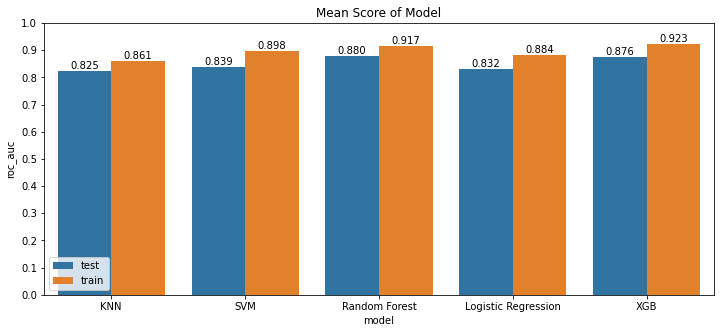

In [183]:
#set figsize
plt.figure(figsize=(12, 5))
plots = sns.barplot(x="model", y="score", data=df_model,
                    ci=None, hue="set_data")
plots.set_title("Mean Score of Model")
plots.bar_label(plots.containers[0], fmt="%.3f")
plots.bar_label(plots.containers[1], fmt="%.3f")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.legend(loc = 3)
plt.ylabel("roc_auc");


## Randomized Search CV

In [91]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [185]:
models_tune = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42),
    "XGB": XGBClassifier(random_state=42)
}

resample_params = {
    "under__sampling_strategy": uniform(0.3, 0.2),
    "over__sampling_strategy" : uniform(0.4,0.5)
}

#model parameters
rf_params = {
    "algo__n_estimators": randint(low=100, high=1000),
    "algo__max_depth": randint(low=1, high=10),
    "algo__max_features": uniform(loc=0.1, scale=1),
    "algo__min_samples_leaf": randint(low=1, high=30)
}

logit_params = {
    "algo__C": uniform(0.01,10),
    'algo__fit_intercept': [True, False]
}

xgb_params = {
    "algo__n_estimators": randint(low=100, high=1000),
    "algo__max_depth": randint(low=1, high=10),
    "algo__subsample": uniform(0.3, 0.8),
    "algo__learning_rate": uniform(0.001, 0.3),
    "algo__gamma": randint(1, 10),
    "algo__reg_alpha": uniform(0.001, 10),
    "algo__reg_lambda": uniform(0.001, 10),
    "algo__colsample_bytree": uniform(0.1, 1),
}


models_params = dict(zip(models_tune, [rf_params,logit_params, xgb_params]))
# add resample params to each item in models_params
for model, params in models_params.items():
    models_params[model].update(resample_params)


In [216]:
from sklearn.model_selection import RandomizedSearchCV

model_dict = {}

for model in models_tune:
        pipeline = clone(pipeline_base)

        pipeline.steps.append(("under", under))
        pipeline.steps.append(("over", over))
        pipeline.steps.append(("algo", models[model]))

        model_dict[model] = RandomizedSearchCV(pipeline, models_params[model], cv=5, scoring='roc_auc', n_iter=25, n_jobs=-1, verbose=0, random_state=42)
        model_dict[model].fit(X_train, y_train)

        print(model)
        print("Best parameters found on training set:")
        print(model_dict[model].best_params_)
        print("Best score found on training set, validation set, and test set :")
        print(model_dict[model].score(X_train, y_train), model_dict[model].best_score_, model_dict[model].score(X_test, y_test))

Random Forest
Best parameters found on training set:
{'algo__max_depth': 9, 'algo__max_features': 0.3962735057040824, 'algo__min_samples_leaf': 13, 'algo__n_estimators': 164, 'over__sampling_strategy': 0.407818203370597, 'under__sampling_strategy': 0.3846802961412739}
Best score found on training set, validation set, and test set :
0.9302521514119173 0.9134324174988284 0.9163424640158722
Logistic Regression
Best parameters found on training set:
{'algo__C': 8.09397348116461, 'algo__fit_intercept': True, 'over__sampling_strategy': 0.4079831261101071, 'under__sampling_strategy': 0.3461787651244298}
Best score found on training set, validation set, and test set :
0.8848338240871182 0.8843464806566839 0.8795418188289327
[23:01:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
Best parameters fo

# Model Evaluation

## ROC curve

In [145]:
def roc_plot(model_dict,X_train,y_train,X_test,y_test):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    for model in model_dict:
        plot_roc_curve(model_dict[model],X_train,y_train,name = model,ax = axes[0])
        plot_roc_curve(model_dict[model],X_test,y_test,name = model,ax = axes[1])

    axes[0].grid(linestyle = "dotted")
    axes[1].grid(linestyle = "dotted")
    axes[0].set_title("Train Set")
    axes[1].set_title("Test Set")
    plt.suptitle("ROC Curves Comparisson")
    plt.show()

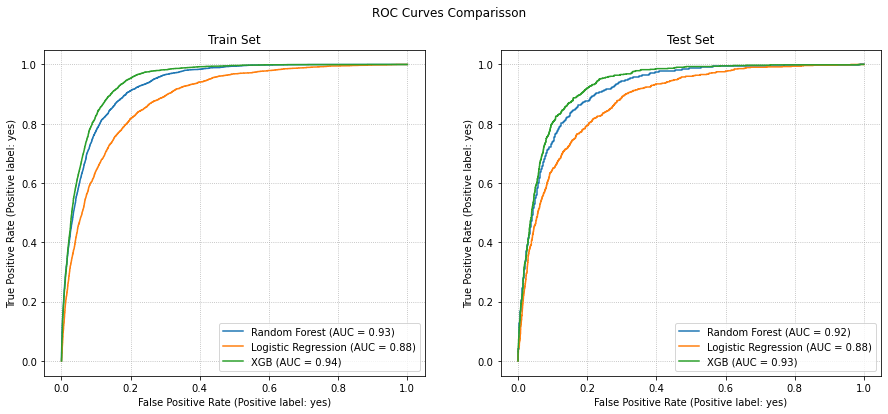

In [217]:
roc_plot(model_dict,X_train,y_train,X_test,y_test)

## Classification Report

In [134]:
def clfr_plot(model, X_train, y_train, X_test, y_test):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    clf_report_train = classification_report(
        y_train, model.predict(X_train), output_dict=True)
    clf_report_test = classification_report(
        y_test, model.predict(X_test), output_dict=True)

    sns.heatmap(pd.DataFrame(
        clf_report_train).iloc[:-1, :].T, annot=True, cmap="YlGnBu", vmin=0, vmax=1, linewidths=0.5,ax = axes[0],cbar = False)
    sns.heatmap(pd.DataFrame(
        clf_report_test).iloc[:-1, :].T, annot=True, cmap="YlGnBu", vmin=0, vmax=1, linewidths=0.5,ax = axes[1])
    
    axes[0].set_title("Train Set")
    axes[1].set_title("Test Set")
    plt.suptitle("Classification report")
    plt.show()


### Random Forest

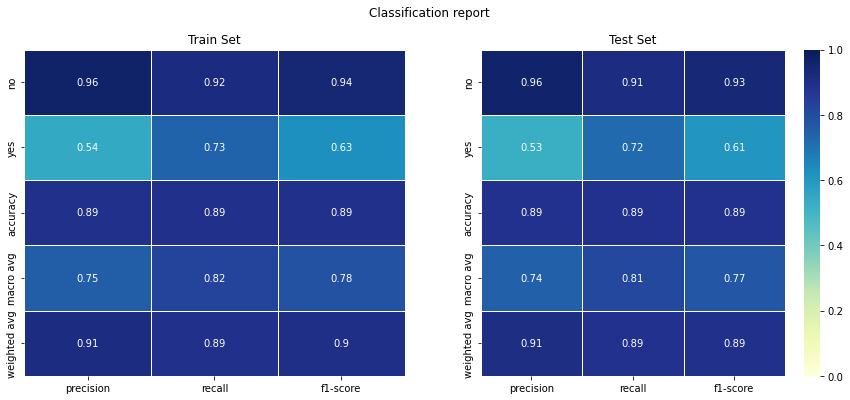

In [218]:
clfr_plot(model_dict["Random Forest"], X_train, y_train, X_test, y_test) 

### Logistic Regression

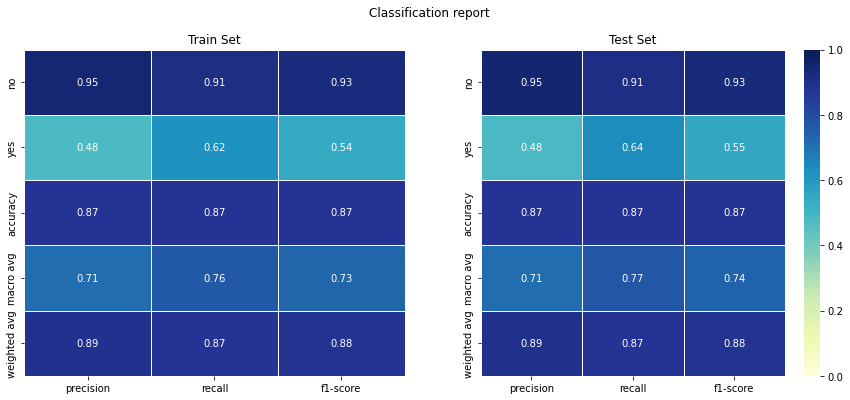

In [219]:
clfr_plot(model_dict["Logistic Regression"], X_train, y_train, X_test, y_test)

### XGBOOST

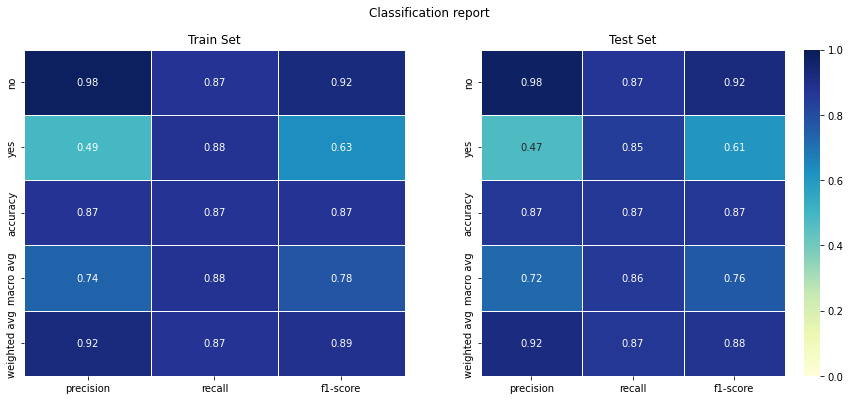

In [220]:
clfr_plot(model_dict["XGB"], X_train, y_train, X_test, y_test)

Ketiga model sepertinya memiliki masalah pada data yang imbalance, ketiganya memiliki skor f1 yang tidak begitu tinggi, XGB paling tinggi hanya 0.56 pada test set. 

Karena skor yang dimiliki rendah, baik pada train set dan test set, model selanjutnya akan menerapkan metode undersampling ataupun oversampling untuk mengatasi data imbalance ini. 

In [154]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, model_dict["XGB"].predict(X_test)))

[[5488  690]
 [ 157  698]]


In [ ]:
joblib.dump(model_dict["Random Forest"], PATH_MODEL + "random_forest.pkl")
joblib.dump(model_dict["Logistic Regression"], PATH_MODEL + "logistic_regression.pkl")
joblib.dump(model_dict["XGB"], PATH_MODEL + "xgb.pkl")
joblib.dump(model_dict, PATH_MODEL + "model_dict.pkl")

['../../artifacts/iteration_3/model_dict.pkl']